In [5]:
from src.data.data_utils import query_mlb_db

In [3]:
kukuchi = 579328
jones = 683003
gallen = 668678

pitcher = kukuchi

In [80]:
if 'a':
    print('test')

test


In [6]:
def get_sequencing_dataset(pitcher, backtest_date=''):

    #for backtesting, add date query to only use past data
    if backtest_date:
       backtest_date = f'and game_date <= "{backtest_date}"' 
    
    pitcher_query_str = f"""
        SELECT game_year, pitch_type, batter, pitch_number, strikes, balls, outs_when_up,
            CASE
                when stand='R' then 1
                else 0
            END AS stand,
            CASE
                when on_1b is not null then 1
                else 0
            END AS on_1b,
            CASE
                when on_2b is not null then 1
                else 0
            END AS on_2b,
            CASE
                when on_3b is not null then 1
                else 0
            END AS on_3b,
            CASE
                when fld_score - bat_score > 0 then 1
                when fld_score - bat_score = 0 then 0
                else -1
            END AS is_winning,
            LAG(pitch_type) OVER (PARTITION BY game_pk, pitcher, at_bat_number ORDER BY pitch_number) AS prev_pitch,
            ROW_NUMBER() OVER (PARTITION BY game_pk, pitcher ORDER BY at_bat_number, pitch_number) AS cumulative_pitch_number
        FROM Statcast
        WHERE pitcher = {pitcher}
            AND pitch_type IS NOT NULL
            and pitch_type <> 'PO'
            AND game_type <> 'E' || 'S'
            and game_pk in (
                select distinct game_pk
                from Statcast
                where pitcher = {pitcher}
                    {backtest_date}
                order by game_date desc
                limit 34
            )
        ORDER BY game_year, at_bat_number, pitch_number
    """
    pitcher_df = query_mlb_db(pitcher_query_str).set_index('batter')
    pitch_arsenal = pitcher_df['pitch_type'].unique()

    sql_pitch_arsenal = ', '.join(pitch_arsenal)
    

    #get datasets
    batter_query = lambda table: f"select batter, {sql_pitch_arsenal} from {table}"
    strike_df = query_mlb_db(batter_query('BatterStrikePctByPitchType')).set_index('batter').add_suffix('_strike')
    woba_df = query_mlb_db(batter_query('BatterAvgWobaByPitchType')).set_index('batter').add_suffix('_woba')


    dataset = pitcher_df.merge(strike_df, left_index=True, right_index=True, how='left')
    dataset = dataset.merge(woba_df, left_index=True, right_index=True, how='left')
    dataset.reset_index(drop=True, inplace=True)
    
    return dataset

df = get_sequencing_dataset(pitcher)

In [7]:
df

,game_year,pitch_type,pitch_number,strikes,balls,outs_when_up,stand,on_1b,on_2b,on_3b,...,prev_pitch,cumulative_pitch_number,FF_strike,CU_strike,SL_strike,CH_strike,FF_woba,CU_woba,SL_woba,CH_woba
0,2023,FF,1,0,0,0,1,0,0,0,...,None,1,-0.638823,-1.524457,-2.029933,-1.611088,0.262675,1.006379,0.155034,-0.526065
1,2023,FF,1,0,0,0,1,0,0,0,...,None,1,-1.159658,-1.331131,-0.914996,-0.142949,0.153579,0.255684,-0.044082,0.382435
2,2023,FF,1,0,0,0,1,0,0,0,...,None,1,0.703899,-1.739937,-1.652027,-2.135514,0.175455,-1.335514,-0.669500,1.115377
3,2023,FF,1,0,0,0,0,0,0,0,...,None,1,-0.638343,-0.628919,-1.709312,-2.084056,-0.237687,-1.166416,-0.619244,-0.358911
4,2023,FF,1,0,0,0,0,0,0,0,...,None,1,-0.601920,-0.318455,-0.150701,-0.121654,0.777027,1.607474,0.060197,1.117506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965,2024,FF,2,1,0,0,1,0,0,0,...,FF,93,0.044748,0.819732,-0.329168,0.316338,-0.468261,0.026619,-0.023806,-0.003369
2966,2024,CH,3,2,0,0,1,0,0,0,...,FF,94,0.044748,0.819732,-0.329168,0.316338,-0.468261,0.026619,-0.023806,-0.003369
2967,2024,FF,1,0,0,1,1,0,0,0,...,None,95,0.062498,-0.291986,-0.524459,-0.512602,0.226678,-0.345025,-0.763404,-0.775137
2968,2024,SL,1,0,0,2,1,0,0,0,...,None,96,-2.112857,0.000000,0.538505,0.000000,-0.743374,0.000000,0.000000,0.000000


In [94]:
print(df['pitch_type'].value_counts())
df['pitch_type'].value_counts() / len(df)

pitch_type
FF    1339
CU     710
SL     688
CH     198
Name: count, dtype: int64


pitch_type
FF    0.456218
CU    0.241908
SL    0.234412
CH    0.067462
Name: count, dtype: float64

In [8]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from copy import deepcopy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

target_col = 'pitch_type'
encoders = {} # to store encoders

le = LabelEncoder()
y = pd.DataFrame(le.fit_transform(df['pitch_type']), columns=[target_col])

encoders[target_col] = deepcopy(le)

X = df.drop(target_col, axis=1)

def encode_cat_cols(X, encoders_dict):
    cat_encoded_dfs = {}
    object_cols = [col for col in X.columns if X[col].dtype == 'object']
    for col in object_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        encoders_dict[col] = deepcopy(le)

    return X, encoders_dict

X, encoders = encode_cat_cols(X, encoders)        

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [23]:
pd.DataFrame(encoders['prev_pitch'].transform([None])).head(50)


,0
0,4


In [87]:
import cupy as cp
#X_train_gpu = cp.asarray(X_train.values).get()
#y_train_gpu = cp.asarray(y_train.values).get()

xgb_params = {"max_depth": (2, 5, 10),
              "learning_rate": (0.01, 0.1, 0.3),
              "n_estimators": (100,300,500)
             }

# perform the paramater grid search using 5-fold cross validation
xgb_opt = GridSearchCV(xgb.XGBClassifier(objective='multi:softprob', 
                                         eval_metric='mlogloss'
                                        ), 
                       param_grid=xgb_params, 
                       cv=5, 
                       scoring='accuracy', 
                       verbose=1, 
                       n_jobs=-1)

# perform fit and make predictions
xgb_opt.fit(X_train, y_train)
y_pred = xgb_opt.predict(X_test)
y_prob = xgb_opt.predict_proba(X_test)
print(xgb_opt.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500}


In [116]:
params = {'objective' : 'multi:softprob',
          'eval_metric': 'mlogloss',      
          'learning_rate': 0.01,
          'max_depth': 2, 
          'n_estimators': 500 
         }

clf = xgb.XGBClassifier(**params)
    
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [117]:
y_pred_proba = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

In [118]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_train, clf.predict(X_train)))
#clf.score(X_test, y_test)

Accuracy: 0.3979591836734694
Accuracy: 0.4967815221507005


In [119]:
#likelihoods = y_pred_proba[np.arange(len(y_pred_proba)), y_test]
#likelihoods.shape
#print(y_pred_proba)
#y_pred_proba[:, y_test['pitch_type']]


-347.3316968381405

In [120]:
import numpy as np
def compute_xgboost_loglik(y_pred_proba, y_test):
    loglik = 0
    for idx, pitch_type in enumerate(y_test['pitch_type']):
        loglik += np.log(y_pred_proba[idx, pitch_type])
    return loglik

def compute_cat_loglik(df, target_col, y_test):
    pitch_cat_prob = (df['pitch_type'].value_counts() / len(df)).reset_index()
    pitch_cat_prob[f'{target_col}_encoded'] = encoders[target_col].transform(pitch_cat_prob[target_col])
    pitch_cat_prob.set_index(f'{target_col}_encoded')
    
    loglik = 0
    for idx, pitch_type in enumerate(y_test[target_col]):
        loglik += np.log(pitch_cat_prob.loc[pitch_type]['count'])
    return loglik

compute_xgboost_loglik(y_pred_proba, y_test)
compute_cat_loglik(df, target_col, y_test)

-486.84916435321804

In [121]:
len(y_test) * np.log(1/4)

-407.5705421692478

In [124]:
probabilities = clf.predict_proba(X_test)
samples = np.apply_along_axis(lambda row: np.random.choice(len(row), size=1, p=row), axis=1, arr=probabilities)
df = pd.DataFrame(encoders[target_col].inverse_transform(np.ravel(samples)))
sample1 = df.value_counts().values

test_df = pd.DataFrame(encoders[target_col].inverse_transform(y_test['pitch_type']))
sample2 = test_df.value_counts().values 


length_diff = len(sample1) - len(sample2)

# Append zeros to the shorter array
if length_diff > 0:
    sample2 = np.append(sample2, np.zeros(length_diff, dtype=sample2.dtype))
elif length_diff < 0:
    sample1 = np.append(sample1, np.zeros(-length_diff, dtype=sample1.dtype))

print(sample1)
print(sample2)

from scipy.stats import chi2_contingency


# Create a contingency table from the two samples
observed = np.array([sample1, sample2])

# Perform the chi-square test of independence
chi2, p, dof, expected = chi2_contingency(observed)

# Print the results
print("Chi-square statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)


[135  71  65  23]
[119  89  63  23]
Chi-square statistic: 3.0641240157480314
P-value: 0.3818437941421461
Degrees of freedom: 3
Expected frequencies: [[127.  80.  64.  23.]
 [127.  80.  64.  23.]]


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

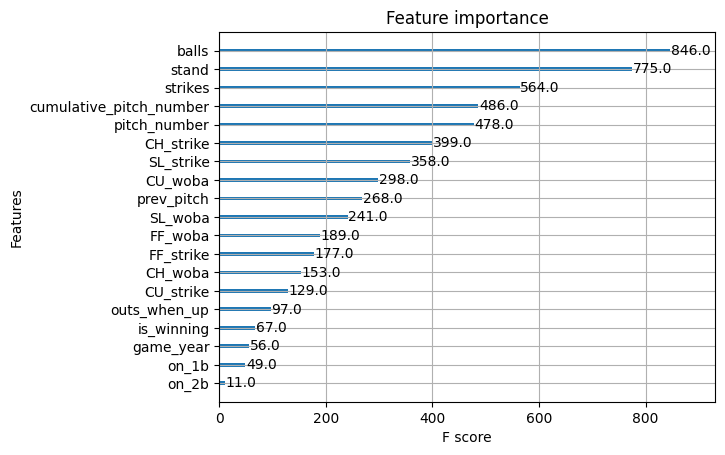

In [107]:
import matplotlib.pyplot as plt

xgb.plot_importance(clf)

In [125]:
#y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.3979591836734694
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.50      0.01      0.02        89
           2       0.40      0.92      0.56       119
           3       0.32      0.11      0.16        63

    accuracy                           0.40       294
   macro avg       0.31      0.26      0.19       294
weighted avg       0.38      0.40      0.27       294



/home/reece/miniconda3/envs/mlb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/reece/miniconda3/envs/mlb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/reece/miniconda3/envs/mlb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [109]:
pd.DataFrame(encoders['pitch_type'].inverse_transform(y_pred), columns=['pitch_type'])['pitch_type'].value_counts()

pitch_type
FF    122
SL     23
CU      2
Name: count, dtype: int64

In [110]:
pd.DataFrame(encoders['pitch_type'].inverse_transform(y_test['pitch_type']), columns=['pitch_type'])['pitch_type'].value_counts()

pitch_type
FF    60
CU    50
SL    27
CH    10
Name: count, dtype: int64

In [128]:
import pandas as pd
from scipy.stats import zscore
from src.data.data_utils import get_mlb_db_engine

def update_woba_strike_tables(min_pitch_count=50, min_hit_count=15, backtest_yr=None):

    if backtest_yr:
        backtest_yr = f'and game_year < {backtest_yr}'
    else:
        backtest_yr = ''

    batter_df = query_mlb_db(f"""
        select batter, pitch_type, type, woba_value
        from Statcast
        where pitch_type <> 'PO' 
            and pitch_type is not null
            and type is not null
            {backtest_yr}
    """)


    """
    get each batters strike percentage for each pitch in pitch arsenal given they have
    at least min_pitch_count of the pitch type thrown to them
    standardize across all batters
    """
    filtered_data = batter_df.groupby(['batter', 'pitch_type']).filter(lambda x: len(x) >= min_pitch_count)
    strike_percentage = filtered_data.groupby(['batter', 'pitch_type'])['type'].apply(lambda x: (x == 'S').mean() * 100)
    strike_percentage_standardized = strike_percentage.groupby('pitch_type').transform(zscore).reset_index()    
    strike_df = strike_percentage_standardized.pivot(index='batter', columns='pitch_type', values='type').fillna(0)

    """
    do the same as above but for avg woba when they hit the ball
    """
    filtered_data = batter_df[batter_df['type'] == 'X'].groupby(['batter', 'pitch_type']).filter(lambda x: (x['type'] == 'X').sum() >= min_hit_count)
    average_woba = filtered_data.groupby(['batter', 'pitch_type'])['woba_value'].mean()
    average_woba_standardized = average_woba.groupby('pitch_type').transform(zscore).reset_index()
    woba_df = average_woba_standardized.pivot(index='batter', columns='pitch_type', values='woba_value').fillna(0)

    #upload df's
    engine = get_mlb_db_engine()

    strike_df.to_sql('BatterStrikePctByPitchType', engine, if_exists='replace')
    woba_df.to_sql('BatterAvgWobaByPitchType', engine, if_exists='replace')
    
update_woba_strike_tables()

In [79]:
test_df['num'] / test_df['num'].sum()
test_df

,pitch_type,num
0,FF,5173
1,SL,2890
2,FC,1364
3,CU,1186
4,CH,1143
